In [138]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import norm, expon, lognorm, t
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')
plt.style.use('bmh')

In [2]:
import pkg_resources
import types

def get_imported_package_versions():
    imported_modules = {}
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            package_name = val.__name__.split(".")[0]
            if package_name not in imported_modules:
                imported_modules[package_name] = None

    versions = []
    for m in pkg_resources.working_set:
        if m.project_name in imported_modules and m.project_name != "pip":
            versions.append(f"{m.project_name}=={m.version}")
    return versions

In [3]:
for package_info in get_imported_package_versions():
    print(package_info)

matplotlib==3.10.7
numpy==2.3.4
pandas==2.3.3
scipy==1.16.3
seaborn==0.13.2


# Preface

While point estimates provide a single value for a statistic of interest, they often fail to capture the inherent uncertainty in the estimation process. For a more complete picture, we require an interval estimate.

Several methods exist to quantify this uncertainty, with the confidence interval being the most widely used. Recalling the formal definition, a confidence interval for a population parameter is an interval estimate, computed from sample data, that has a specified probability of containing the true parameter value (note, this interpritation may not be entirely precise).

$$ P \big( \theta \in [L(X), U(X)]) = 1 - \alpha$$

In theory, we aim for an interval with an exact confidence level (e.g., 95%). In practice, however, constructing such an exact interval is often infeasible, making approximation sufficient.

$$ P \big( \theta \in [L(X), U(X)]) \approx 1 - \alpha$$

This leads to a trade-off: the balance between a confidence interval's coverage (how often it contains the true parameter, i.e. its correctness) and its precision (the width of the interval). Our objective is to construct an interval that achieves the required coverage with the minimal possible width.

The purpose of this notebook is to empirically evaluate different methods for constructing confidence intervals and to measure their effectiveness, specifically their coverage and precision under various scenarios.

# Notation

* $X_i$ - i-th sample
* $\theta$ - population statistic
* $\hat{\theta}$ - sample statistic 
* $\hat{\theta}^*$ - bootstrap statistic
* $t^*$ - bootstrap t-statistic
* $n$ - number of observations in a sample
* $B$ - number of bootstrap resamples
* $N_s$ - number of simulations

# Notes on bootstrap

Before moving on to the methodology and implementation details, let's recall some facts about bootstrap, since two of three methods are based on this technique.

* The bootstrap distribution is centered at sample statistic $\hat{\theta}$, not the population statistic $\theta$. \
  It means that we do not use the bootstrap to get better estimate of $\theta$, instead we use the bootstrap to measure the uncertainty of $\hat{\theta}$ and get the sense of the sampling distribution.

In [4]:
rng = np.random.RandomState(123)

# population distribution
population = np.concatenate([rng.exponential(scale=1.1, size=200_000), rng.normal(loc=10, scale=1.5, size=100_000)])

# sampling distribution
n_samples = 1000
sample_size = 100

sampling_distribution = []
for _ in range(n_samples):
    sample = rng.choice(population, size=sample_size, replace=False)
    sampling_distribution.append(sample.mean())
sampling_distribution = np.array(sampling_distribution)

# bootstrap distribution
n_samples = 2
sample_size = 100
bootstrap_rounds = 10_000

bootstrap_distribution = []
bootstrap_data = {}
for i in range(n_samples):
    sample = rng.choice(population, size=sample_size, replace=False)
    for _ in range(bootstrap_rounds):
        bootstrap_sample = rng.choice(sample, size=sample_size, replace=True)
        bootstrap_distribution.append(bootstrap_sample.mean())
    bootstrap_data[f'sample_{i}'] = {'sample': sample, 'bootstrap': np.array(bootstrap_distribution)}

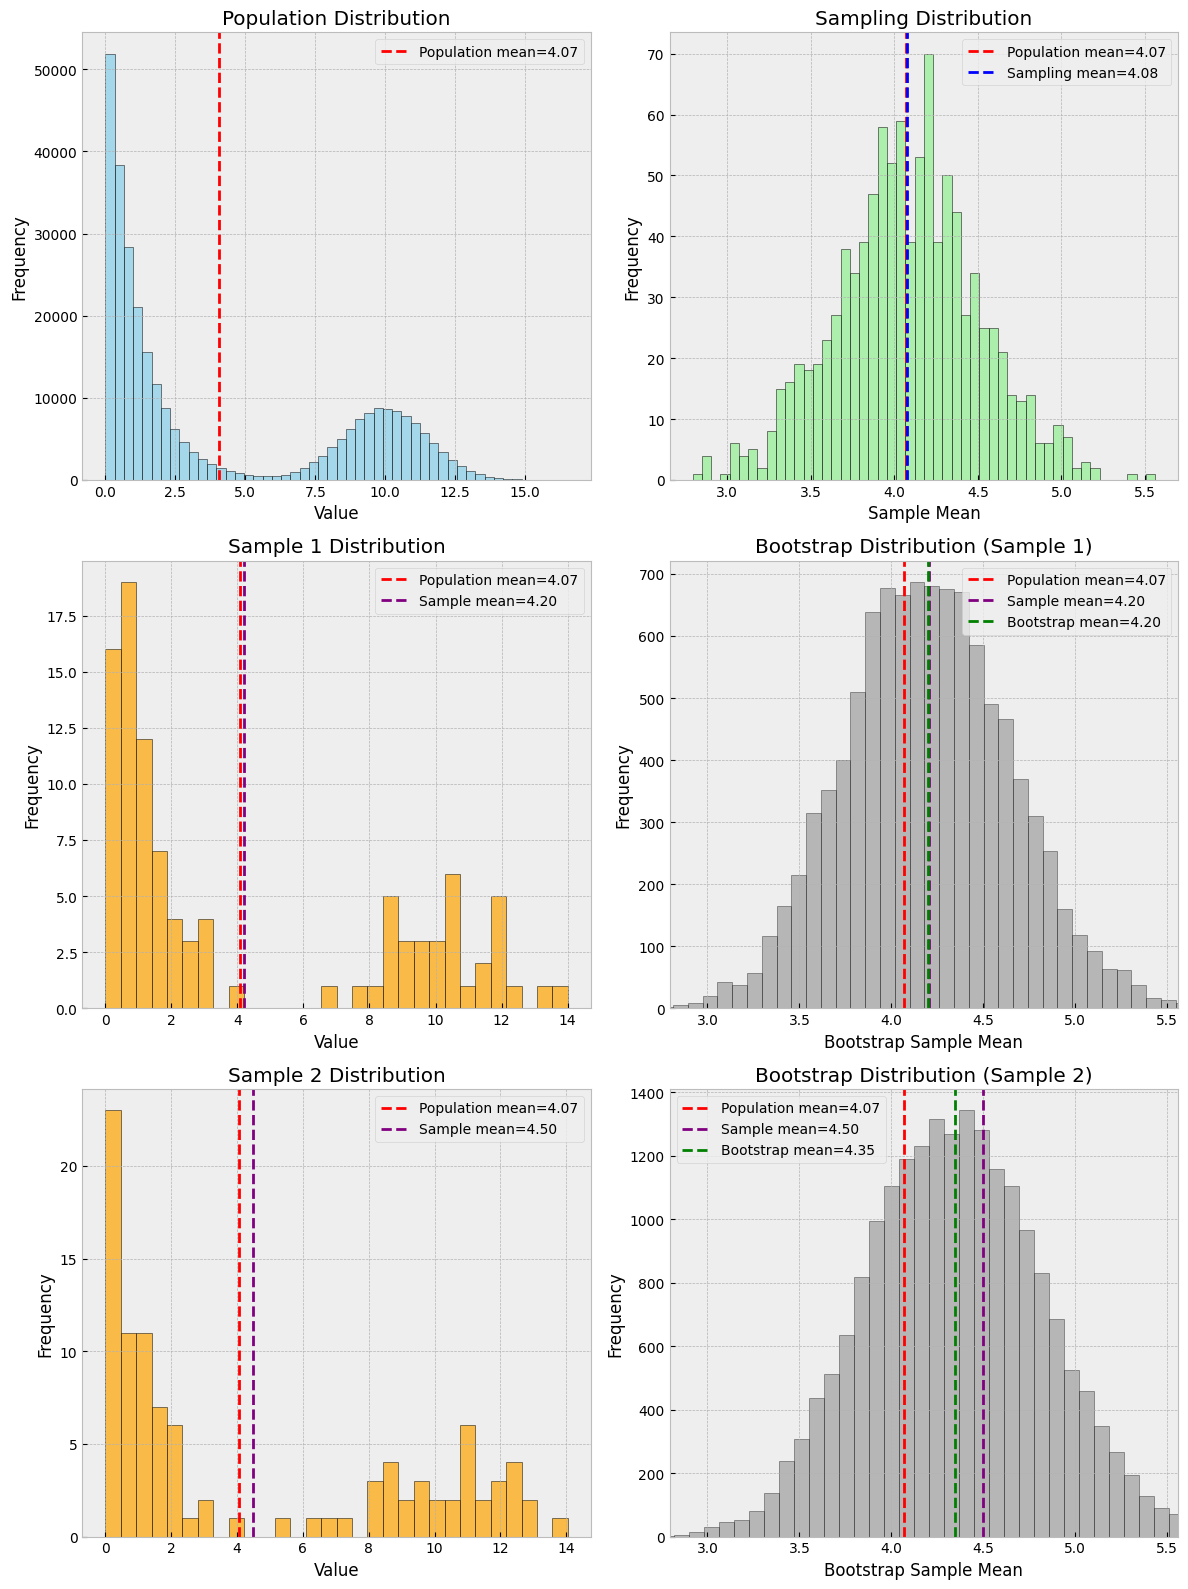

In [6]:
fig, axes = plt.subplots(3, 2, figsize=(12, 16))

# plot population distribution
axes[0, 0].hist(population, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].axvline(population.mean(), color='red', linestyle='--', label=f'Population mean={population.mean():.2f}')
axes[0, 0].set_title('Population Distribution')
axes[0, 0].set_xlabel('Value')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()

# plot sampling distribution
axes[0, 1].hist(sampling_distribution, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0, 1].axvline(population.mean(), color='red', linestyle='--', label=f'Population mean={population.mean():.2f}')
axes[0, 1].axvline(sampling_distribution.mean(), color='blue', linestyle='--', label=f'Sampling mean={sampling_distribution.mean():.2f}')
axes[0, 1].set_title('Sampling Distribution')
axes[0, 1].set_xlabel('Sample Mean')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()

# plot individual samples and their boostrap distribution
for i in range(2):
    sample = bootstrap_data[f'sample_{i}']['sample']
    bootstrap_distribution = bootstrap_data[f'sample_{i}']['bootstrap']

    # sample distribution
    axes[i+1, 0].hist(sample, bins=30, alpha=0.7, color='orange', edgecolor='black')
    axes[i+1, 0].axvline(population.mean(), color='red', linestyle='--', label=f'Population mean={population.mean():.2f}')
    axes[i+1, 0].axvline(sample.mean(), color='purple', linestyle='--', label=f'Sample mean={sample.mean():.2f}')
    axes[i+1, 0].set_title(f'Sample {i+1} Distribution')
    axes[i+1, 0].set_xlabel('Value')
    axes[i+1, 0].set_ylabel('Frequency')
    axes[i+1, 0].legend()

    # bootstrap distribution
    axes[i+1, 1].hist(bootstrap_distribution, bins=50, alpha=0.5, color='gray', edgecolor='black')
    axes[i+1, 1].axvline(population.mean(), color='red', linestyle='--', label=f'Population mean={population.mean():.2f}')
    axes[i+1, 1].axvline(sample.mean(), color='purple', linestyle='--', label=f'Sample mean={sample.mean():.2f}')
    axes[i+1, 1].axvline(bootstrap_distribution.mean(), color='green', linestyle='--', label=f'Bootstrap mean={bootstrap_distribution.mean():.2f}')
    axes[i+1, 1].set_xlim((sampling_distribution.min(), sampling_distribution.max()))
    axes[i+1, 1].set_title(f'Bootstrap Distribution (Sample {i+1})')
    axes[i+1, 1].set_xlabel('Bootstrap Sample Mean')
    axes[i+1, 1].set_ylabel('Frequency')
    axes[i+1, 1].legend()

plt.tight_layout()
plt.show()

* The bootstrap distribution is used to estimate the standard error of the sampling distribution, i.e. the variability of the bootstrap means approximates the variability of the sample means that we would get if we were to sample from the population repeatedly. \
  In other words, we can say that the bootstrap can be used to estimate the spread and shape of the sampling distribution.

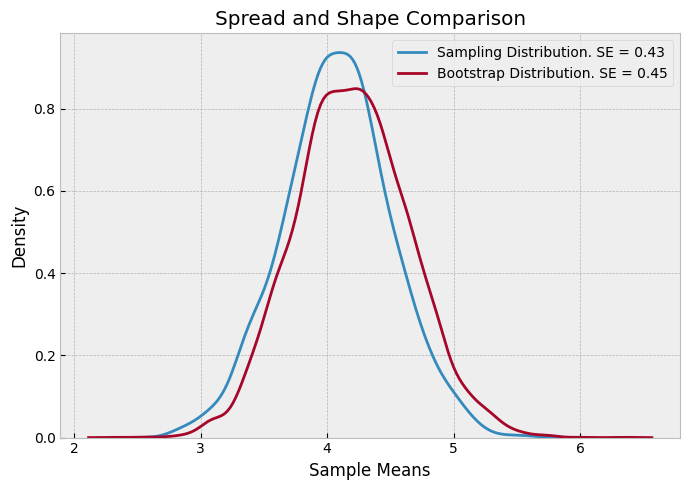

In [9]:
bootstrap_distribution = bootstrap_data['sample_0']['bootstrap']

plt.figure(figsize=(7, 5))

sns.kdeplot(sampling_distribution, label=f'Sampling Distribution. SE = {sampling_distribution.std(ddof=1):.2f}')
sns.kdeplot(bootstrap_distribution, label=f'Bootstrap Distribution. SE = {bootstrap_distribution.std(ddof=1):.2f}')
plt.xlabel('Sample Means')
plt.ylabel('Density')
plt.title('Spread and Shape Comparison')
plt.legend()

plt.tight_layout()
plt.show()

* Bootstrap is a poor estimate of the sampling distribution for statistics that are based on a small number of observations, such as the median, maximum, and quantile. This effect is more noticeable in small samples.

* Bootstrap may not work well for small samples, as they may not accurately represent the population. Boostrap is always reflects the data, as we have seen above.

* Bootstrap can be used to check if the Central Limit Theorem applies to a given dataset and to what extent.


# Methodology

The following methods will be evaluated:

1. $t$ interval \
   This is well-known formula based interval, which heavily relies on the Central Limit Theorem.
   $$CI = \big[ \hat{\theta} - t_{\frac{\alpha}{2}, n-1} \cdot SE(\hat{\theta}), \ \hat{\theta} + t_{\frac{\alpha}{2}, n-1} \cdot SE(\hat{\theta} \big]$$
3. percentile interval \
   This is yet another well-known interval, which is based on the quantiles of the empirical boostrap distribution.
   $$CI = \big[ \hat{\theta}^*_{\frac{\alpha}{2}}, \ \hat{\theta}^*_{1 - \frac{\alpha}{2}} \big]$$
5. bootstrap $t$ interval \
   The $t$ statistic doesn't always follow a $t$ distribution, especially when the data is highly skewed. This interval is based on an estimate of the distribution of the $t$ statistic for a given dataset.
   $$CI  = \big[ \hat{\theta} - t_{1 - \frac{\alpha}{2}}^* \cdot SE(\hat{\theta}), \ \hat{\theta} - t_{\frac{\alpha}{2}}^* \cdot SE(\hat{\theta}) \big], \ \text{where} \ t^* = \frac{(\hat{\theta}^* - \hat{\theta})}{SE(\hat{\theta}^*)}$$

The methods will be explored in the following scenarios:

    Distribution size:
        1. Small (n = 50)
        2. Large (n = 1000)

    Distribution type:
        1. Bimodal distribution
        2. Log-normal distribution
        3. Exponential distribution
        4. Student distribution

The following metrics will be used for evaluation:

1. Empirical coverage (EC)
   $$EC = \frac{1}{N_{s}} \sum_i I \big( \theta \in CI(X_i)  \big)$$
2. Coverage adjusted width (CAW)
   $$CAW = \mathbb{E} \big[ \text{Width} | \text{Coverage} = 1 \big] = \frac{1}{\sum_i I \big( \theta \in CI(X_i)  \big)} \cdot \sum_i \big[ W_i \cdot I \big( \theta \in CI(X_i) \big]  \big) $$

# Evaluation

In [270]:
class ConfidenceIntervalEvaluator:
    """
    A class to evaluate the performance of different confidence interval methods
    across various population distributions and sample sizes.
    """
    
    def __init__(self, population_size=500_000, n_simulations=1000, n_bootstrap=10_000, alpha=0.05, seed=42, n_jobs=-1):
        """
        Initialize the evaluator with simulation parameters.
        
        Arguments:
            population_size: Size of the finite population to sample from
            n_simulations: Number of Monte Carlo simulations to run
            n_bootstrap: Number of bootstrap resamples for bootstrap methods
            alpha: Significance level (1 - confidence level)
            seed: Random seed for reproducibility
            n_jobs: Number of parallel jobs for simulation computing
        """
        self.population_size = population_size
        self.N = n_simulations
        self.B = n_bootstrap
        self.alpha = alpha
        self.rng = np.random.RandomState(seed) 
        self.n_jobs = n_jobs
        self.results = []
        
    def generate_bimodal_data(self, n):
        """Generate bimodal data from exponential and gamma distributions."""
        exponential = self.rng.exponential(scale=1, size=n)
        gamma = self.rng.gamma(shape=10, scale=1.5, size=n)
        return np.concatenate([exponential, gamma])
    
    def generate_lognormal_data(self, n):
        """Generate data from lognormal distribution."""
        return self.rng.lognormal(mean=0, sigma=1, size=n)
    
    def generate_exponential_data(self, n):
        """Generate data from exponential distribution."""
        return self.rng.exponential(scale=1, size=n)

    def generate_student_data(self, n):
        """Generate data from Student's t-distribution (heavy-tailed)."""
        return self.rng.standard_t(df=5, size=n)
    
    def t_interval(self, data):
        """
        Calculate classical t-based confidence interval.
        
        Uses the t-distribution assuming normality.
        """
        n = len(data)
        sample_mean = np.mean(data)
        se = np.std(data, ddof=1) / np.sqrt(n)
        t_critical = stats.t.ppf(1 - self.alpha/2, n-1)
        return sample_mean - t_critical * se, sample_mean + t_critical * se
    
    def percentile_interval(self, data, rng):
        """
        Calculate bootstrap percentile confidence interval.
        
        Uses empirical quantiles of bootstrap distribution.
        """
        n = len(data)
        bootstrap_samples = rng.choice(data, size=(self.B, n), replace=True)
        bootstrap_means = np.mean(bootstrap_samples, axis=1)
        return np.quantile(bootstrap_means, self.alpha/2), np.quantile(bootstrap_means, 1 - self.alpha/2)
    
    def bootstrap_t_interval(self, data, rng):
        """
        Calculate bootstrap t confidence interval.
        
        Bootstrap version of t interval that doesn't assume that t is follow t distribution.
        """
        n = len(data)
        sample_mean = np.mean(data)
        sample_se = np.std(data, ddof=1) / np.sqrt(n)
        
        bootstrap_samples = rng.choice(data, size=(self.B, n), replace=True)
        bootstrap_means = np.mean(bootstrap_samples, axis=1)
        bootstrap_ses = np.std(bootstrap_samples, ddof=1, axis=1) / np.sqrt(n)
        
        with np.errstate(divide='ignore', invalid='ignore'):
            bootstrap_t_stats = (bootstrap_means - sample_mean) / bootstrap_ses
            bootstrap_t_stats = np.where(bootstrap_ses > 0, bootstrap_t_stats, 0)
        
        t_lower = np.quantile(bootstrap_t_stats, self.alpha/2)
        t_upper = np.quantile(bootstrap_t_stats, 1 - self.alpha/2)
        
        return sample_mean - t_upper * sample_se, sample_mean - t_lower * sample_se
    
    def run_experiment(self, population, n, true_mean, seed):
        """
        For a given population, sample size, and true mean, evaluate
        all confidence interval methods on one random sample.
        """
        rng = np.random.RandomState(seed)
        sample = rng.choice(population, size=n, replace=False)
        
        methods = {
            "t_interval": lambda data: self.t_interval(data),
            "percentile_interval": lambda data: self.percentile_interval(data, rng),
            "bootstrap_t_interval": lambda data: self.bootstrap_t_interval(data, rng)
        }
        
        # Evaluate each method on the current sample
        results = {}
        for name, func in methods.items():
            try:
                lower, upper = func(sample)
                results[name] = {
                    'width': upper - lower,
                    'coverage': 1 if lower <= true_mean <= upper else 0
                }
            except Exception as e:
                print(f"Error in {name}: {e}")
                results[name] = {'width': np.nan, 'coverage': 0}
                
        return results
    
    def run_experiments(self):
        """
        Evaluates all combinations of:
        - Sample sizes (small and large)
        - Population distributions (bimodal, lognormal, exponential, student's t)
        - Confidence interval methods (t, percentile, bootstrap-t)
        """
        # Define experimental conditions
        sample_sizes = [50, 1000]
        populations = [
            ("bimodal", self.generate_bimodal_data(self.population_size)),
            ("lognormal", self.generate_lognormal_data(self.population_size)),
            ("exponential", self.generate_exponential_data(self.population_size)),  
            ("student", self.generate_student_data(self.population_size))
        ]
        true_means = {name: np.mean(population) for name, population in populations}
        method_names = ["t_interval", "percentile_interval", "bootstrap_t_interval"]
        
        # Iterate through all experimental conditions
        for n in sample_sizes:
            for name, population in populations:
                print(f"Running: n={n}, distribution={name}")
                true_mean = true_means[name]
                
                # Initialize storage for results
                coverages = {method: np.zeros(self.N) for method in method_names}
                widths = {method: np.zeros(self.N) for method in method_names}

                # Generate random seeds for reproducible parallel computing
                seeds = self.rng.randint(0, 2**31 - 1, size=self.N)
                
                # Run simulations in parallel
                all_results = Parallel(n_jobs=self.n_jobs, backend='loky')(
                    delayed(self.run_experiment)(population, n, true_mean, seed)
                    for seed in tqdm(seeds)
                )
                
                # Aggregate results from all simulations
                for i, results in enumerate(all_results):
                    for method, result in results.items():
                        coverages[method][i] = result['coverage']
                        widths[method][i] = result['width']
                        
                # Calculate performance metrics for each method
                for method in method_names:
                    coverage = coverages[method]
                    width = widths[method]
                    
                    # Empirical coverage
                    ec = np.mean(coverage)
                    # Coverage-adjusted width
                    mask = coverage == 1
                    caw = np.mean(width[mask]) if mask.any() else np.nan
                    
                    # Store results
                    self.results.append({
                        'sample_size': n,
                        'distribution': name,
                        'method': method,
                        'empirical_coverage': ec,
                        'coverage_adjusted_width': caw
                    })
                    
        result_df = pd.DataFrame(self.results)
        result_df.to_csv('study_results.csv', index=False)
        
        return result_df

In [278]:
def plot_results(results_df):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    ax1 = axes[0]
    small_n_data = results_df[results_df['sample_size'] == 50]
    sns.barplot(data=small_n_data, x='distribution', y='empirical_coverage', hue='method', ax=ax1)
    ax1.axhline(y=0.95, color='red', linestyle='--', label='Nominal Coverage (0.95)')
    ax1.set_title('Empirical Coverage (n=50)')
    ax1.set_ylabel('Empirical Coverage')
    ax1.set_ylim(0.8, 1.0)
    ax1.legend()

    ax2 = axes[1]
    sns.barplot(data=small_n_data, x='distribution', y='coverage_adjusted_width', hue='method', ax=ax2)
    ax2.set_title('Coverage Adjusted Width (n=50)')
    ax2.set_ylabel('Coverage Adjusted Width')
    ax2.legend()
    
    ax3 = axes[2]
    large_n_data = results_df[results_df['sample_size'] == 1000]
    sns.barplot(data=large_n_data, x='distribution', y='empirical_coverage', hue='method', ax=ax3)
    ax3.axhline(y=0.95, color='red', linestyle='--', label='Nominal Coverage (0.95)')
    ax3.set_title('Empirical Coverage (n=1000)')
    ax3.set_ylabel('Empirical Coverage')
    ax3.set_ylim(0.8, 1.0)
    ax3.legend()
    
    ax4 = axes[3]
    sns.barplot(data=large_n_data, x='distribution', y='coverage_adjusted_width', hue='method', ax=ax4)
    ax4.set_title('Coverage Adjusted Width (n=1000)')
    ax4.set_ylabel('Coverage Adjusted Width')
    ax4.legend()

    plt.savefig('study_plots.png', dpi=300)
    
    plt.tight_layout()
    plt.show()

In [277]:
results_df.to_csv('study_result.csv', index=False)

In [272]:
experiment = ConfidenceIntervalEvaluator(n_simulations=10_000, n_bootstrap=10_000, alpha=0.05)
results_df = experiment.run_experiments()

Running: n=50, distribution=bimodal


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:18<00:00, 127.34it/s]


Running: n=50, distribution=lognormal


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:49<00:00, 203.43it/s]


Running: n=50, distribution=exponential


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 314.96it/s]


Running: n=50, distribution=student


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:36<00:00, 275.49it/s]


Running: n=1000, distribution=bimodal


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [05:35<00:00, 29.77it/s]


Running: n=1000, distribution=lognormal


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [05:12<00:00, 31.97it/s]


Running: n=1000, distribution=exponential


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [05:12<00:00, 32.04it/s]


Running: n=1000, distribution=student


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [05:12<00:00, 31.96it/s]


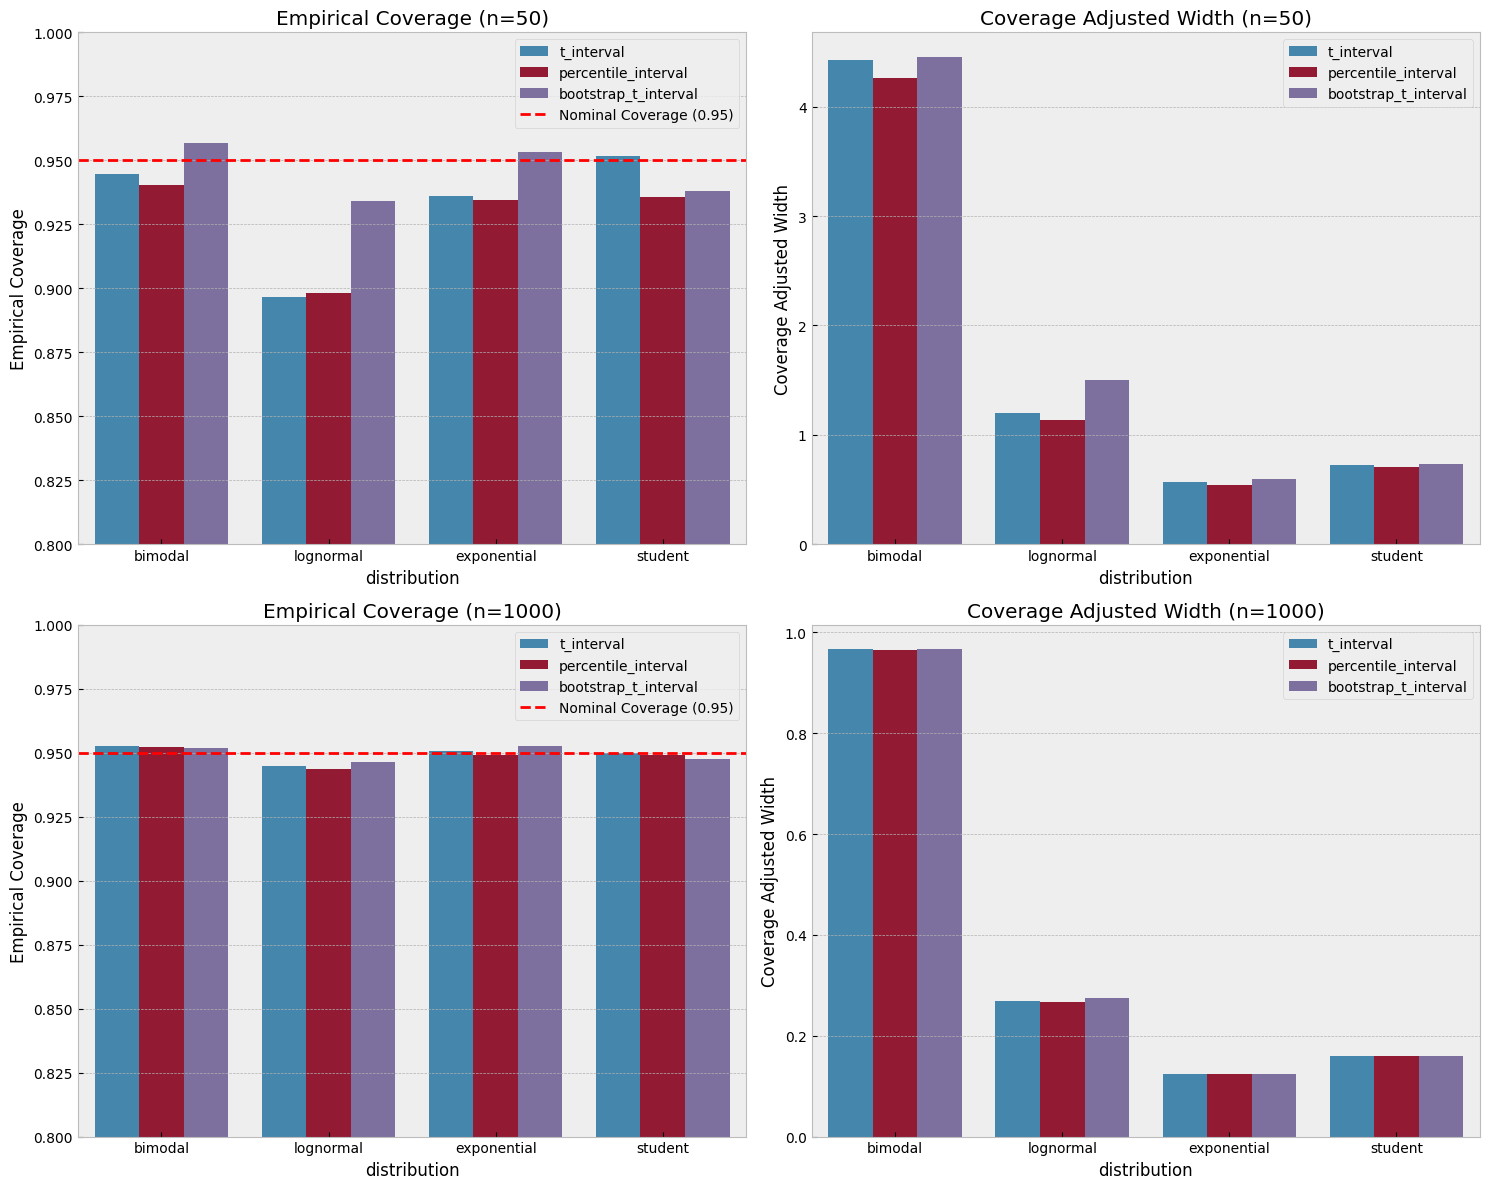

In [279]:
plot_results(results_df)